## Necessary Imports

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

## Formal Settings

In [13]:
train_data_dir = 'data/'

In [14]:
img_width, img_height = 224, 224
batch_size = 32
epochs = 100
num_classes = 5

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


## Modeling

In [16]:
def build_model(input_size,nb_classes):
  inputs = Input(input_size)

  conv1 = Conv2D(8, 3, input_shape=input_size, activation='relu', padding='same',
                         kernel_initializer='he_normal')(inputs)
  conv2 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
  merge1 = concatenate([conv1, conv2], axis=3)

  mp1 = MaxPooling2D((2,2))(merge1)
  drop1 = Dropout(0.2)(mp1)

  conv3 = Conv2D(8, 3, activation='relu', padding='same',
                        kernel_initializer='he_normal')(drop1)
  conv4 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
  merge2 = concatenate([conv3, conv4], axis=3)

  mp2 = MaxPooling2D((2, 2))(merge2)
  drop2 = Dropout(0.35)(mp2)
  conv5 = Conv2D(16, 3, activation='relu', padding='same',
                        kernel_initializer='he_normal')(drop2)
  conv6 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
  merge3 = concatenate([conv5, conv6], axis=3)

  mp3 = MaxPooling2D((2, 2))(merge3)

  conv7 = Conv2D(16, 3, activation='relu', padding='same',
                        kernel_initializer='he_normal')(mp3)
  conv8 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
  merge3 = concatenate([conv7, conv8], axis=3)

  conv9 = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(merge3)
  conv10 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
  merge4 = concatenate([conv9, conv10], axis=3)

  mp4 = MaxPooling2D((2, 2))(merge4)

  conv11 = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(mp4)
  conv12 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)
  merge5 = concatenate([conv11, conv12], axis=3)

  conv13 = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(merge5)
  conv14 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv13)
  merge6 = concatenate([conv13, conv14], axis=3)

  conv15 = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(merge6)
  conv16 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv15)
  merge7 = concatenate([conv15, conv16], axis=3)

  mp5 = MaxPooling2D((2, 2))(merge7)

  drop4 = Dropout(0.45)(mp5)
  flat = Flatten()(drop4)

  dense1 = Dense(nb_classes, activation='softmax')(flat)

  return Model(inputs, dense1)

In [17]:
model = build_model((img_width, img_height , 3) , num_classes)

## Model Compiling

In [18]:
loss = CategoricalCrossentropy(name='loss')
metrics = [CategoricalAccuracy(name='accuracy')]
optimizer = Adam(learning_rate=0.005 , name='optimizer')

In [19]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 224, 224, 8)  224         ['input_2[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 224, 224, 8)  584         ['conv2d_16[0][0]']              
                                                                                                  
 concatenate_8 (Concatenate)    (None, 224, 224, 16  0           ['conv2d_16[0][0]',        

## Fitting The Model

In [21]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
)
rlrop = ReduceLROnPlateau(
    monitor="val_loss",
    min_lr=0.001,
    factor=0.3,
    patience=2
)

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[mc , rlrop, es]
)

Epoch 1/100
91/91 [==============================] - 45s 475ms/step - loss: 1.1102 - accuracy: 0.5971 - val_loss: 1.0285 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - 43s 466ms/step - loss: 0.8589 - accuracy: 0.6954 - val_loss: 0.8878 - val_accuracy: 0.6861 - lr: 0.0010
Epoch 3/100
91/91 [==============================] - 43s 465ms/step - loss: 0.8174 - accuracy: 0.7030 - val_loss: 0.8110 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 4/100
91/91 [==============================] - 51s 553ms/step - loss: 0.7824 - accuracy: 0.7133 - val_loss: 0.8595 - val_accuracy: 0.6534 - lr: 0.0010
Epoch 5/100
91/91 [==============================] - 47s 514ms/step - loss: 0.7720 - accuracy: 0.7147 - val_loss: 1.3199 - val_accuracy: 0.5199 - lr: 0.0010
Epoch 6/100
91/91 [==============================] - 43s 466ms/step - loss: 0.7480 - accuracy: 0.7278 - val_loss: 0.8780 - val_accuracy: 0.6932 - lr: 0.0010


## Stats

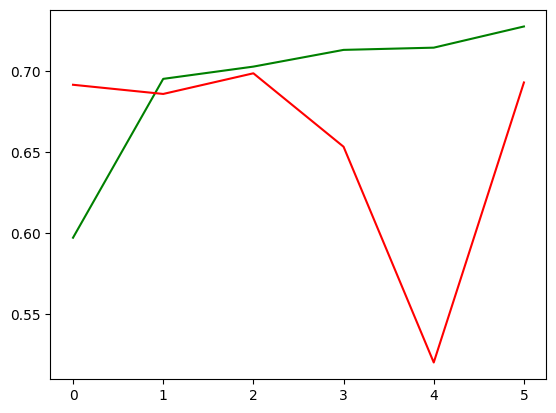

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'] , color='green')
plt.plot(history.history['val_accuracy'] , color='red')
plt.show()

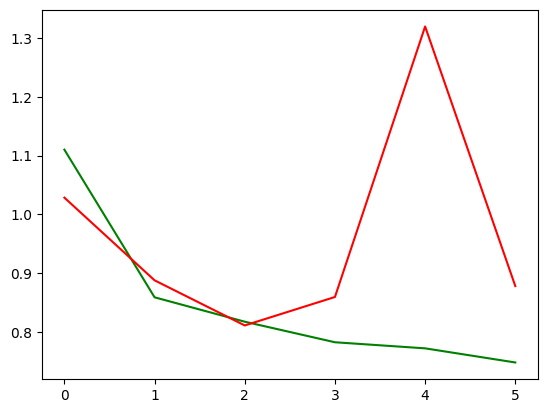

In [31]:
plt.plot(history.history['loss'] , color='green')
plt.plot(history.history['val_loss'] , color='red')
plt.show()

## Saving Settings and Model

In [23]:
from pickle import dump
with open('classes.h5' , 'wb') as f:
    dump(train_generator.class_indices , f)